# Lab 06: Gene Expression

---
author: Brady Brooks
date: October 18, 2024
embed-resources: true
---

## Introduction

In this report, I develop a model to detect and classify what type of cancer someone may have. The goal is to work towards a proof of concept that a model can be created to detect and classify a person may have. Ideally, the model will be accurate enough to become a universal cancer detection and classifier. In order to create this model, I am testing numerous classifiers such as Logistic Regression and a random forest model.

## Methods

In [2]:
# imports
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import warnings

### Data

In [3]:
# load data
cancer_train = pd.read_parquet(
    "https://cs307.org/lab-06/data/cancer-train.parquet",
)
cancer_test = pd.read_parquet(
    "https://cs307.org/lab-06/data/cancer-test.parquet",
)

In [4]:
cancer_train

,cancer,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_1990,gene_1991,gene_1992,gene_1993,gene_1994,gene_1995,gene_1996,gene_1997,gene_1998,gene_1999
0,BRCA,0.0,3.149861,1.913454,5.562355,9.638586,0.0,4.302421,0.511670,0.000000,...,7.300691,8.383307,1.187198,0.000000,7.350471,0.0,4.634587,7.082415,9.727447,1.187198
1,LUAD,0.0,6.237034,5.043235,6.297397,10.391415,0.0,7.669941,0.913033,0.000000,...,6.322446,7.815595,13.809095,0.913033,7.651052,0.0,7.476074,4.733739,8.510863,0.000000
2,BRCA,0.0,3.856896,2.394981,6.758277,9.585513,0.0,7.409009,1.242023,0.000000,...,6.845515,9.194823,5.667696,0.000000,7.748253,0.0,5.567421,5.203158,7.364879,0.000000
3,PRAD,0.0,4.279924,3.606963,5.706613,9.716581,0.0,8.244226,0.402613,0.000000,...,6.598611,8.199118,5.024218,0.000000,7.607907,0.0,5.705281,6.278007,9.725383,0.000000
4,BRCA,0.0,3.359788,4.199986,6.144766,9.141834,0.0,9.014135,1.061776,0.626486,...,7.062651,9.670708,4.243707,0.000000,8.156811,0.0,7.363487,5.384844,8.703443,1.894876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,KIRC,0.0,3.069737,3.623200,6.744955,9.591219,0.0,7.254254,0.000000,0.000000,...,7.333665,8.365334,5.481444,0.000000,7.307674,0.0,5.723447,5.401791,9.067881,0.000000
124,BRCA,0.0,3.534497,3.064866,6.638882,10.010206,0.0,7.899387,0.000000,0.000000,...,7.080615,9.968912,10.501041,0.000000,8.866052,0.0,5.276806,4.941073,8.548240,0.000000
125,BRCA,0.0,4.087463,3.786596,6.385845,9.544964,0.0,8.062856,0.000000,0.000000,...,5.842979,9.931033,10.234817,0.000000,8.384568,0.0,7.033423,5.749534,8.132371,0.000000
126,LUAD,0.0,3.272889,4.529234,7.134909,9.504362,0.0,5.668893,0.000000,0.000000,...,7.300966,8.040350,11.972872,0.000000,7.592607,0.0,5.026256,6.137704,8.780947,1.167936


The source of this data is from "The Cancer Genome Atlas Pan-Cancer Analysis Project" accessed fromm synapse.org.

The train and test data are made up of a mix of observations. The observations consist of what cancer someone has and what their gene 0 through 1999 are.

##### Response

cancer
-   [object] the clinically determined cancer type, one of:
    - BRCA: Breast Invasive Carcinoma
    - PRAD: Prostate Adenocarcinoma
    - KIRC: Kidney Renal Clear Cell Carcinoma
    - LUAD: Lung Adenocarcinoma
    - COAD: Colon Adenocarcinoma

##### Features

gene_
-   [float64] gene expression quantification as measured by https://www.illumina.com/content/dam/illumina-support/documents//products/datasheets/datasheet_hiseq_systems.pdf platform

In [5]:
# summary statistics
cancer_train.shape

(128, 2001)

The train dataset has 128 observations and 2001 columns. This is actually pretty unique because there are so few observations to the amount of features used to predict the target variable.

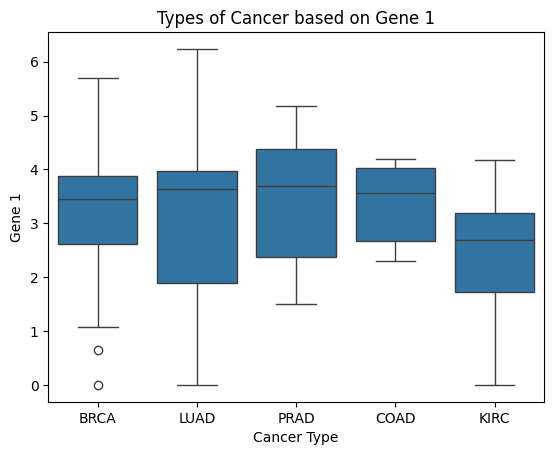

In [6]:
# visualizations
sns.boxplot(data=cancer_train, x='cancer', y='gene_1')
plt.title("Types of Cancer based on Gene 1")
plt.xlabel("Cancer Type")
plt.ylabel("Gene 1")
plt.show()

This is a visualization to visualize how each gene may be used to classify which cancer type a person has.

### Models

To develop a model, I tuned numerous Logistic Regression models and a Histogram Gradient Boosting model. For both, I considered various values of the available tuning parameters. 

All of the features from the data are numeric variables. For the preprocessing of these features, I scaled them and imputed the mean value.

Further tuning was perfomed by cross-validation using a grid search of the specified parameters. Finally, the models were compared using their accuracy. 

In [7]:
# process data for ML
# create X and y for train
X_train = cancer_train.drop(columns=["cancer"])
y_train = cancer_train["cancer"]

# create X and y for test
X_test = cancer_test.drop(columns=["cancer"])
y_test = cancer_test["cancer"]

In [21]:
# train models
numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
# pipeline for numeric
numeric_preprocessor = Pipeline(steps=[
    ("MedianImputer", SimpleImputer(strategy="mean")), 
    ("Standardize", StandardScaler()),
    ])
# pipeline for categorical
categorical_preprocessor = Pipeline(steps=[
    ("ModelImputer", SimpleImputer(strategy="most_frequent")), 
    ("OneHotEncoder", OneHotEncoder(handle_unknown="ignore")),
    ])
# column transformer 
preprocessor = ColumnTransformer([
    ("NumericProcessing", numeric_preprocessor, numeric_features),
    ("CategoricalProcessing", categorical_preprocessor, categorical_features),
])
# full pipeline
pipeline = Pipeline(steps=[
    ("Preprocessor", preprocessor),
    ("Regressor", LogisticRegression())
])

In [22]:
param_grid = [ 
    {"Regressor": [LogisticRegression()],
     "Regressor__solver":  ["liblinear"],
     "Regressor__fit_intercept": [True, False],
     "Regressor__penalty":  ["l1", "l2"]},
     {"Regressor": [LogisticRegression()]},
    {"Regressor": [HistGradientBoostingClassifier()],
        "Regressor__learning_rate": [0.1, 0.01,],
        "Regressor__max_iter": [1000],
        "Regressor__max_depth": [None, 3],
        "Regressor__l2_regularization": [0.1,1.0],
    }
]

In [ ]:
warnings.filterwarnings("ignore")
mod = GridSearchCV(pipeline, param_grid = param_grid, n_jobs=-1, cv=5, verbose=3, scoring="accuracy")
_ = mod.fit(X_train, y_train)

## Results

In [24]:
# report model metrics
mod.best_params_

{'Regressor': LogisticRegression(),
 'Regressor__fit_intercept': True,
 'Regressor__penalty': 'l1',
 'Regressor__solver': 'liblinear'}

Of the models considered, the model with the highest accuracy was a Logistic Regression with an intercept, penalty of l1, and the liblinear solver.

In [25]:
mod.best_score_

np.float64(0.9923076923076923)

The best model achieved a cross-validation accuracy of 0.9923076923076923.

In [26]:
mod.score(X_test, y_test)

1.0

The best model achieved a test accuracy of 1.0.

## Discussion

Note that with a small train dataset, the model was able to almost predict the test dataset with 100% accuracy. The model could potentially be improved by testing out more available tuning parameters for the Logistic Regression model since it was just shy of 100% accuracy. Now that we have proved that building a model to detect and classifty cancer can work well, I believe we should continue to put more effort into finding more data to impove this model and hopefully use in practice. By creating an accurate cancer detecter and classifier, a model like this could be used to help save lives across the globe.

### Conclusion

To conclude, I believe the model is not quite ready for practice as there is not enough training data. Though with more data, I can see this model being used in the future as a universal cancer detector and classifier. I have proven that a cancer detector and classifier can work and that we should put more resources into expanding it, so we can put it into practice and help save lives.

In [ ]:
from joblib import dump 
dump(mod, "gene-expression.joblib")